## Random Forest Implementation on scaled non-reduced dataset

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Take sample for (initial) tests

In [4]:
#df_scaled_sample = df_scaled.sample(n=1000, random_state=seed)
df_scaled_sample = df_scaled

Train-Test Split

In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [6]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.7724850099933378
F1 score: [0.78351823 0.76026676]


## Grid Search CV - 1

In [8]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

model = RandomForestClassifier(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
The parameters with the highest score:  {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [10]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                                params  mean_test_score
119  {'bootstrap': True, 'max_depth': 30, 'min_samp...         0.772428
18   {'bootstrap': True, 'max_depth': None, 'min_sa...         0.772178
91   {'bootstrap': True, 'max_depth': 20, 'min_samp...         0.771429
74   {'bootstrap': True, 'max_depth': 20, 'min_samp...         0.771262
6    {'bootstrap': True, 'max_depth': None, 'min_sa...         0.771095
121  {'bootstrap': True, 'max_depth': 30, 'min_samp...         0.771095
231  {'bootstrap': False, 'max_depth': 20, 'min_sam...         0.770929
118  {'bootstrap': True, 'max_depth': 30, 'min_samp...         0.770929
143  {'bootstrap': True, 'max_depth': 30, 'min_samp...         0.770762
243  {'bootstrap': False, 'max_depth': 20, 'min_sam...         0.770679


Metrics for RF-baseline-GS-CV1:
Accuracy: 0.7728
Weighted F1: 0.7727
Weighted Precision: 0.7728
Weighted Recall: 0.7728
Macro-Averaged Precision: 0.7728
Macro-Averaged Recall: 0.7720
F1: [0.78362944 0.76086957]
Precision: [0.77380952 0.77169275]
classification report
              precision    recall  f1-score   support

     Class 0       0.77      0.79      0.78      1556
     Class 1       0.77      0.75      0.76      1446

    accuracy                           0.77      3002
   macro avg       0.77      0.77      0.77      3002
weighted avg       0.77      0.77      0.77      3002

Confusion Matrix


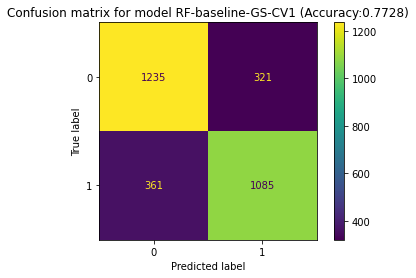

In [11]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('RF-baseline-GS-CV1', y_test, predictions)

In [12]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7728181212524984
Parameters from place:  1   {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7711525649566955
Parameters from place:  2   {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7688207861425717
Parameters from place:  3   {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7714856762158561
Parameters from place:  4   {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7784810126582279
Parameters from place:  5   {'bootstrap': True, 'max_depth': 30, 'min_sampl

In [13]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [14]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.7784810126582279
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [15]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=42, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy for chosen parameters: 0.9505206164098292
Parameters from place:  1   {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy for chosen parameters: 0.9582673885880882
Parameters from place:  2   {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.9349437734277385
Parameters from place:  3   {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy for chosen parameters: 0.9794252394835485
Parameters from place:  4   {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy for chosen parameters: 0.9908371511870054
Parameters from place:  5   {'bootstrap': True, 'max_depth': 30, 'min_sampl

In [16]:
accuracies=[]
max_depths=[]
for i in reversed(range(1,15)):
  model = RandomForestClassifier(random_state=seed, max_depth=i)
  model.fit(X_train, y_train)
  predictions = model.predict(X_train)
  accuracy = accuracy_score(y_train, predictions)
  max_depths.append(i)
  accuracies.append(accuracy)
  print("Accuracy for max depth :", i, " ", accuracy)

Accuracy for max depth : 14   0.8925447730112454
Accuracy for max depth : 13   0.8711370262390671
Accuracy for max depth : 12   0.8478134110787172
Accuracy for max depth : 11   0.826905456059975
Accuracy for max depth : 10   0.8065805914202415
Accuracy for max depth : 9   0.7911703456892961
Accuracy for max depth : 8   0.778259058725531
Accuracy for max depth : 7   0.7631820074968763
Accuracy for max depth : 6   0.751103706788838
Accuracy for max depth : 5   0.7429404414827155
Accuracy for max depth : 4   0.7286130778842149
Accuracy for max depth : 3   0.7178675551853394
Accuracy for max depth : 2   0.7076218242399
Accuracy for max depth : 1   0.6936276551436902


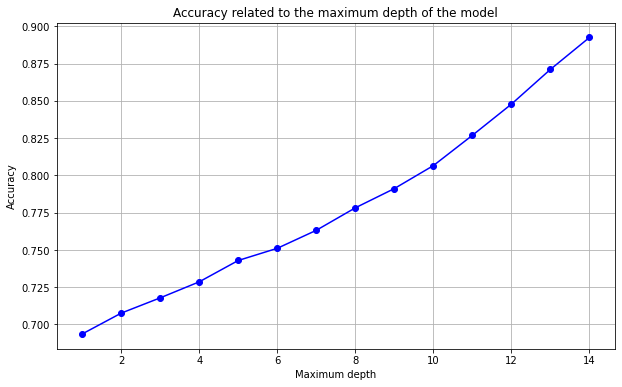

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies, marker='o', linestyle='-', color='b')

plt.title('Accuracy related to the maximum depth of the model')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [18]:
best_accuracy = 0
best_report = None
best_predictions = None
y_best_predictions = None
all_reports = []

for i in range(100):
  random_state_fit = np.random.randint(1000)

  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=random_state_fit)
  

  model = RandomForestClassifier(random_state=seed, **best_tuple[1])
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  current_accuracy = accuracy_score(y_test, predictions)

  report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
  all_reports.append(report)
  print(current_accuracy)

  if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_report = report
        best_predictions = predictions
        y_best_predictions = y_test

def average_classification_report(reports):
    metrics = ['precision', 'recall', 'f1-score']
    avg_report = {}
    for metric in metrics:
        avg_report[metric] = sum(r['macro avg'][metric] for r in reports) / len(reports)
    avg_report['accuracy'] = sum(r['accuracy'] for r in reports) / len(reports)
    return avg_report

avg_report = average_classification_report(all_reports)

print("Best Classification Report:")
print(classification_report(y_best_predictions, best_predictions, zero_division=0))
print("Best Accuracy:", best_accuracy)
print()
print("Average Classification Report:")
for metric, score in avg_report.items():
    print(f"{metric}: {score:.4f}")

0.7828114590273151
0.7734843437708194
0.7744836775483012
0.7758161225849434
0.770819453697535
0.7674883411059293
0.7791472351765489
0.7868087941372418
0.7788141239173884
0.7721518987341772
0.7858094603597602
0.7628247834776816
0.7778147901399067
0.7841439040639574
0.7741505662891406
0.7754830113257828
0.7734843437708194
0.7758161225849434
0.7941372418387741
0.7814790139906729
0.7704863424383744
0.77381745502998
0.7811459027315123
0.7781479013990673
0.7861425716189208
0.7698201199200533
0.790473017988008
0.7788141239173884
0.7804796802131913
0.7701532311792139
0.7754830113257828
0.7871419053964024
0.7564956695536309
0.7784810126582279
0.7771485676215856
0.7694870086608927
0.7718187874750166
0.7771485676215856
0.7781479013990673
0.7728181212524984
0.7801465689540307
0.762491672218521
0.7754830113257828
0.7778147901399067
0.7791472351765489
0.7694870086608927
0.7911392405063291
0.7741505662891406
0.7678214523650899
0.7774816788807462
0.7724850099933378
0.7811459027315123
0.780146568954030

Metrics for RF-baseline-Shuffled_best:
Accuracy: 0.7941
Weighted F1: 0.7940
Weighted Precision: 0.7944
Weighted Recall: 0.7941
Macro-Averaged Precision: 0.7945
Macro-Averaged Recall: 0.7939
F1: [0.80012937 0.78777473]
Precision: [0.78739656 0.80153739]
classification report
              precision    recall  f1-score   support

     Class 0       0.79      0.81      0.80      1521
     Class 1       0.80      0.77      0.79      1481

    accuracy                           0.79      3002
   macro avg       0.79      0.79      0.79      3002
weighted avg       0.79      0.79      0.79      3002

Confusion Matrix


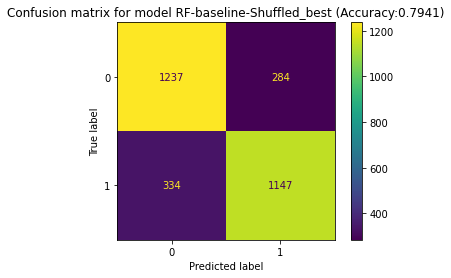

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
RF-baseline-Shuffled_best,0.794137,0.794034,0.794373,0.794137,0.794467,0.793879,[0.80012937 0.78777473],[0.78739656 0.80153739]


In [19]:
calculate_metrics('RF-baseline-Shuffled_best', y_best_predictions, best_predictions)